# 12-Lead ECG Demo

## Imports & Requirements

In [26]:
#Comment if installed
!pip install wfdb
!pip install tensorflow_addons
!pip install ecg_plot

#from google.colab import drive
#drive.mount('/content/drive/')
#import sys
#sys.path.insert(0,'/content/drive/MyDrive/COLAB')

#Change to physionet_utilities
import physionet_utilities as pc
import ecg_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

## ECG Sample Plot

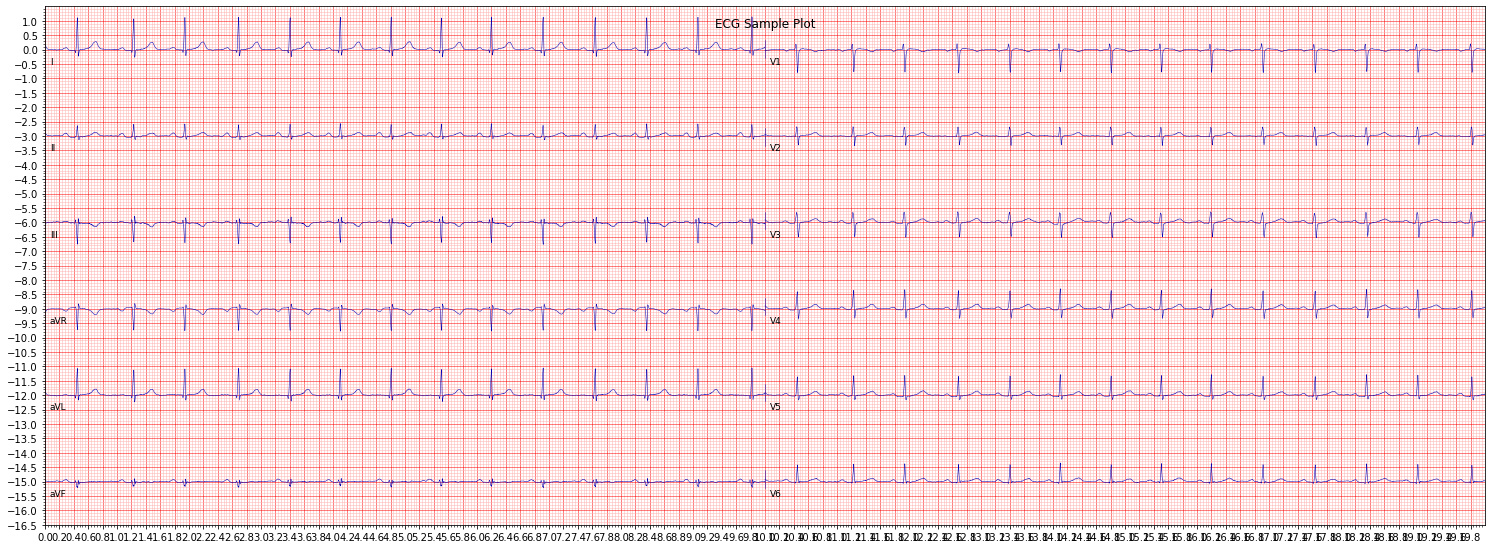

In [27]:
def plot_ecg(path):
    ecg_data = pc.load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='ECG Sample Plot')
    ecg_plot.show()
plot_ecg("Data/GeorgiaDB/E00001.mat")

## Data

<AxesSubplot:title={'center':'Distribution of ECG signal Lengths'}, xlabel='Length', ylabel='Number of Samples'>

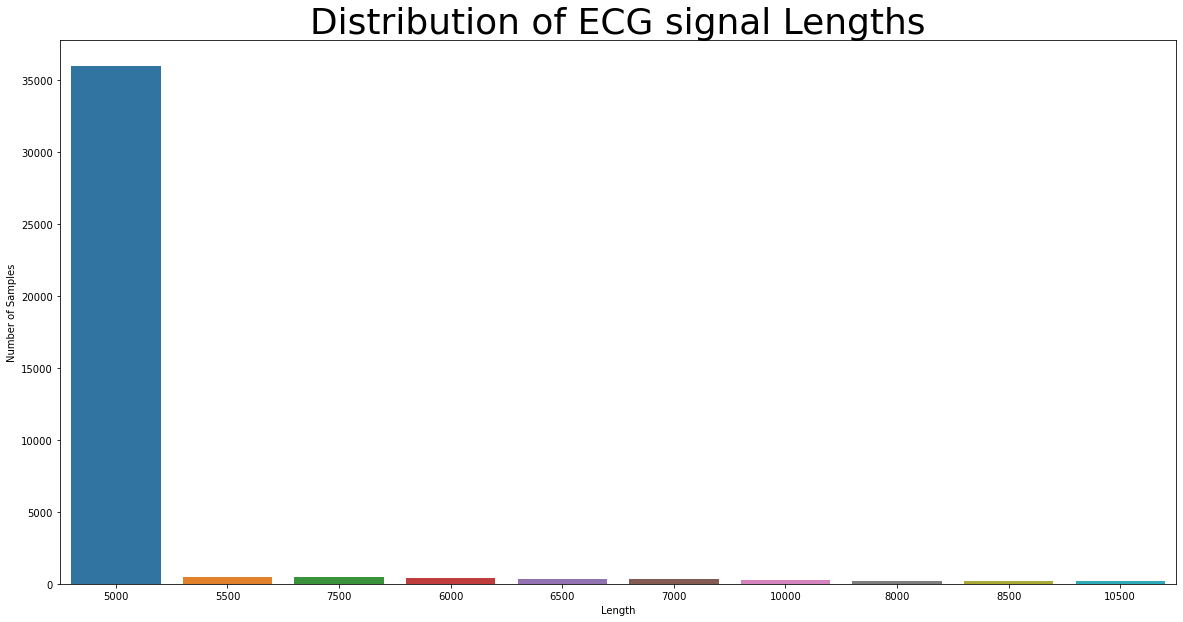

In [28]:
gender, age, labels, ecg_filenames = pc.import_key_data("Data/")
ecg_filenames = np.asarray(ecg_filenames)

import os
signal_lenght=[]
for subdir, dirs, files in sorted(os.walk("Data/")):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith(".mat"):
            data, header_data = pc.load_challenge_data(filepath)
            splitted = header_data[0].split()
            signal_lenght.append(splitted[3])
signal_lenght_df = pd.DataFrame(signal_lenght)
signal_count=signal_lenght_df[0].value_counts()
plt.figure(figsize=(20,10))
plt.xlabel("Length")
plt.ylabel("Number of Samples")
plt.title("Distribution of ECG signal Lengths",fontsize =36)
sns.barplot(signal_count[:10,].index, signal_count[:10,].values)


In [29]:
age, gender = pc.import_gender_and_age(age, gender)

gender data shape: 42585
age data shape: 42585


In [30]:

SNOMED_scored=pd.read_csv("Data/mappings/SNOMED_mappings_scored.csv", sep=";")
SNOMED_unscored=pd.read_csv("Data/mappings/SNOMED_mappings_unscored.csv", sep=";")
df_labels = pc.make_undefined_class(labels,SNOMED_unscored)


y , snomed_classes = pc.onehot_encode(df_labels)

The classes we will look at are encoded as SNOMED CT codes:
['10370003' '111975006' '164889003' '164890007' '164909002' '164917005'
 '164934002' '164947007' '17338001' '251146004' '270492004' '284470004'
 '39732003' '426177001' '426627000' '426783006' '427084000' '427172004'
 '427393009' '445118002' '47665007' '59118001' '59931005' '63593006'
 '698252002' '713426002' '713427006' 'undefined class']
classes: 27


### Diagnosis Distribution

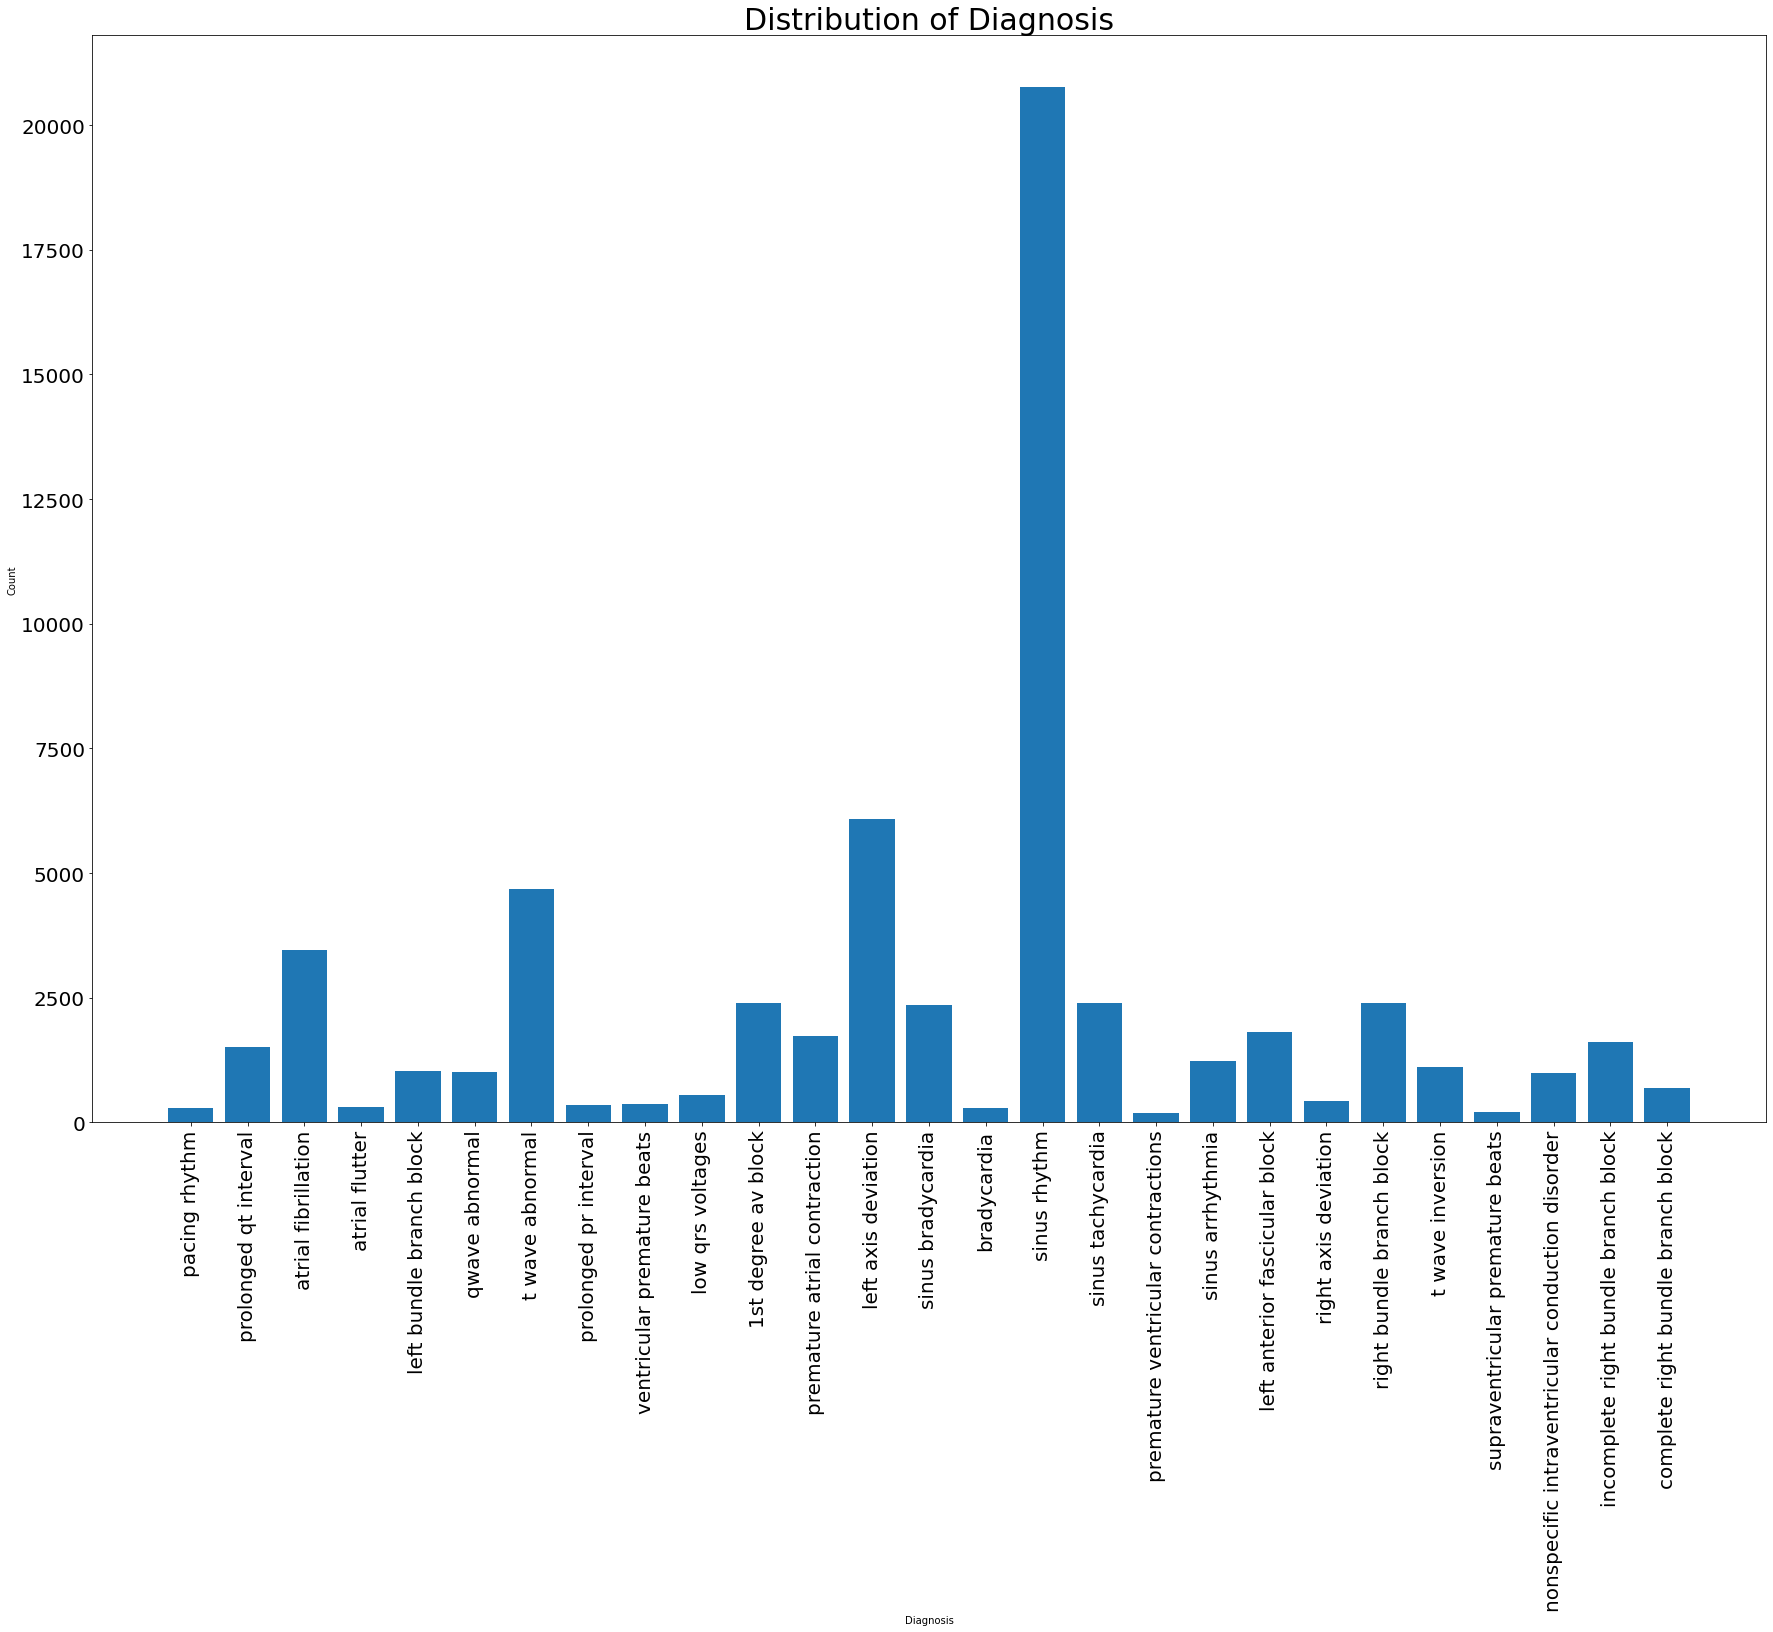

In [31]:
import physionet_utilities as pc
snomed_abbr = []
for j in range(len(snomed_classes)):
    for i in range(len(SNOMED_scored.iloc[:,1])):
        if (str(SNOMED_scored.iloc[:,1][i]) == snomed_classes[j]):
            snomed_abbr.append(SNOMED_scored.iloc[:,2][i])
            
snomed_abbr = np.asarray(snomed_abbr)

pc.plot_classes(snomed_classes, SNOMED_scored,y)

### K-Folds Split

In [32]:
y_all_comb = pc.get_labels_for_all_combinations(y)
print("Total number of unique combinations of diagnosis: {}".format(len(np.unique(y_all_comb))))



Total number of unique combinations of diagnosis: 1414


In [33]:

folds = pc.split_data(labels, y_all_comb)

Training split: 38326
Validation split: 4259


### Batch-Generator

In [34]:
order_array = folds[0][0]

#### - Helper functions for Batch Generation

In [35]:

def shuffle_batch_generator_demo(batch_size, gen_x,gen_y, gen_z): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    batch_demo_data = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            batch_demo_data[i] = next(gen_z)

        X_combined = [batch_features, batch_demo_data]
        yield X_combined, batch_labels
        
def shuffle_batch_generator(batch_size, gen_x,gen_y): 
    np.random.shuffle(order_array)
    batch_features = np.zeros((batch_size,5000, 12))
    batch_labels = np.zeros((batch_size,snomed_classes.shape[0])) #drop undef class
    while True:
        for i in range(batch_size):

            batch_features[i] = next(gen_x)
            batch_labels[i] = next(gen_y)
            
        yield batch_features, batch_labels

def generate_y_shuffle(y_train):
    while True:
        for i in order_array:
            y_shuffled = y_train[i]
            yield y_shuffled


def generate_X_shuffle(X_train):
    while True:
        for i in order_array:
                #if filepath.endswith(".mat"):
                    data, header_data = pc.load_challenge_data(X_train[i])
                    X_train_new = pad_sequences(data, maxlen=5000, truncating='post',padding="post")
                    X_train_new = X_train_new.reshape(5000,12)
                    yield X_train_new

def generate_z_shuffle(age_train, gender_train):
    while True:
        for i in order_array:
            gen_age = age_train[i]
            gen_gender = gender_train[i]
            z_train = [gen_age , gen_gender]
            yield z_train

### Weight calculation

In [36]:
new_weights=pc.calculating_class_weights(y)

keys = np.arange(0,27,1)
weight_dictionary = dict(zip(keys, new_weights.T[1]))
weight_dictionary



{0: 71.2123745819398,
 1: 14.073033707865168,
 2: 6.153901734104046,
 3: 68.02715654952077,
 4: 20.453890489913544,
 5: 21.019249753208292,
 6: 4.556494757115344,
 7: 62.625,
 8: 58.33561643835616,
 9: 38.29586330935252,
 10: 8.894110275689224,
 11: 12.314921920185078,
 12: 3.4986033519553073,
 13: 9.026070368800339,
 14: 73.93229166666667,
 15: 1.0253539439468362,
 16: 8.868179925031237,
 17: 113.25797872340425,
 18: 17.171370967741936,
 19: 11.789867109634551,
 20: 49.86533957845433,
 21: 8.864487926727726,
 22: 19.14793165467626,
 23: 99.03488372093024,
 24: 21.35656970912738,
 25: 13.216945996275605,
 26: 31.174963396778917}

### Learning Rate Reduction

In [37]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_AUC', factor=0.1, patience=1, verbose=1, mode='max',
    min_delta=0.0001, cooldown=0, min_lr=0
)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=2)

In [38]:
from scipy import optimize

def thr_chall_metrics(thr, label, output_prob):
    return -pc.compute_challenge_metric_for_opt(label, np.array(output_prob>thr))

## Model

In [39]:
def RESNET():
    n_feature_maps = 64
    input_shape = (5000,12)
    input_layer = keras.layers.Input(input_shape)

    # BLOCK 1

    conv_x = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=8, padding='same')(input_layer)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps, kernel_size=1, padding='same')(input_layer)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_1 = keras.layers.add([shortcut_y, conv_z])
    output_block_1 = keras.layers.Activation('relu')(output_block_1)

    # BLOCK 2

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_1)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # expand channels for the sum
    shortcut_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=1, padding='same')(output_block_1)
    shortcut_y = keras.layers.BatchNormalization()(shortcut_y)

    output_block_2 = keras.layers.add([shortcut_y, conv_z])
    output_block_2 = keras.layers.Activation('relu')(output_block_2)

    # BLOCK 3

    conv_x = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=8, padding='same')(output_block_2)
    conv_x = keras.layers.BatchNormalization()(conv_x)
    conv_x = keras.layers.Activation('relu')(conv_x)

    conv_y = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=5, padding='same')(conv_x)
    conv_y = keras.layers.BatchNormalization()(conv_y)
    conv_y = keras.layers.Activation('relu')(conv_y)

    conv_z = keras.layers.Conv1D(filters=n_feature_maps * 2, kernel_size=3, padding='same')(conv_y)
    conv_z = keras.layers.BatchNormalization()(conv_z)

    # no need to expand channels because they are equal
    shortcut_y = keras.layers.BatchNormalization()(output_block_2)

    output_block_3 = keras.layers.add([shortcut_y, conv_z])
    output_block_3 = keras.layers.Activation('relu')(output_block_3)
    
    # FINAL

    gap_layer = keras.layers.GlobalAveragePooling1D()(output_block_3)

    output_layer = keras.layers.Dense(27, activation='softmax')(gap_layer)

    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.BinaryAccuracy(
        name='accuracy', dtype=None, threshold=0.5),tf.keras.metrics.Recall(name='Recall'),tf.keras.metrics.Precision(name='Precision'), 
                    tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        summation_method="interpolation",
        name="AUC",
        dtype=None,
        thresholds=None,
        multi_label=True,
        label_weights=None,
    )])


    return model

In [40]:
model = RESNET()

In [41]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 5000, 12)]   0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 5000, 64)     6208        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 5000, 64)     256         conv1d_11[0][0]                  
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 5000, 64)     0           batch_normalization_12[0][0]     
____________________________________________________________________________________________

## Training

### Fitting (Or loading weights)

In [42]:

#batchsize = 30

#model.fit(x=shuffle_batch_generator(batch_size=batchsize, gen_x=generate_X_shuffle(ecg_filenames), #gen_y=generate_y_shuffle(y)), epochs=100,verbose=1, steps_per_epoch=(len(order_array)/batchsize), #validation_data=pc.generate_validation_data(ecg_filenames,y,folds[0][1]), validation_freq=1, #class_weight=weight_dictionary, callbacks=[reduce_lr,early_stop])

model.load_weights("Models/resnet_model.h5")

In [43]:
y_pred = model.predict(x=pc.generate_validation_data(ecg_filenames,y,folds[0][1])[0])

init_thresholds = np.arange(0,1,0.05)

all_scores = pc.iterate_threshold(y_pred, ecg_filenames, y ,folds[0][1])


0.15308402697860948
0.32875918841264007
0.34985584728875585
0.2940206955766956
0.19595443760533293
0.07997571845651817
-0.02185702814827151
-0.13204143650107408
-0.22888349921086848
-0.3227451291235877
-0.4045975865789842
-0.4791398979592908
-0.54519340814365
-0.6133984144263117
-0.6705016453234677
-0.7157237223532422
-0.7516268951381696
-0.7782523941552397
-0.7980536368966347
-0.8164122211659212


### Optimization

In [44]:
new_best_thr = optimize.fmin(thr_chall_metrics, args=(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],y_pred), x0=init_thresholds[all_scores.argmax()]*np.ones(27))#
print(pc.compute_challenge_metric_for_opt(pc.generate_validation_data(ecg_filenames,y,folds[0][1])[1],(y_pred>new_best_thr)*1))#

Optimization terminated successfully.
         Current function value: -0.352572
         Iterations: 119
         Function evaluations: 338
0.35257232338858563


## Results

### Confusion Matrix

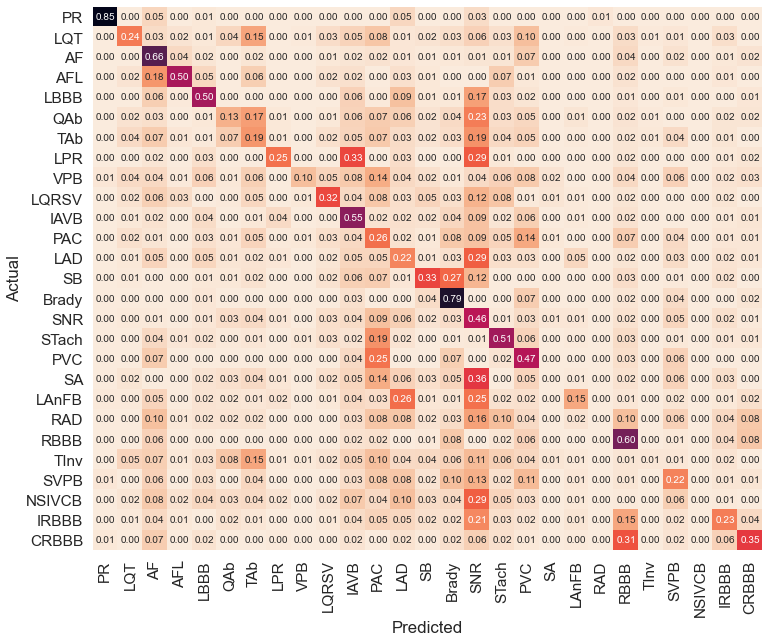

In [45]:
pc.plot_normalized_conf_matrix(y_pred, ecg_filenames, y, folds[0][1], new_best_thr, snomed_classes,snomed_abbr)
#plt.savefig("confusion_matrix_resnet.png", dpi = 100)

## Predicting a single file for demo purposes

In [262]:
import scipy.io as sio

data_mat = sio.loadmat('Data/GeorgiaDB/E10342.mat')
data = np.asarray(data_mat['val'], dtype=np.int16)

In [259]:
test = np.transpose(data)
test = np.expand_dims(test, axis=0)

In [260]:
p = model.predict(test)

In [261]:
print(snomed_classes[np.argmax(p)])
print(snomed_abbr[np.argmax(p)])

ventricular premature beats
VPB
